# SARIMA (continuation of ARIMA notebook)

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [13]:
data = pd.read_csv('data.csv')

In [14]:
# Take the log difference to make data stationary

data['data'] = np.log(data['data'])
data['data'] = data['data'].diff()
data = data.drop(data.index[0])

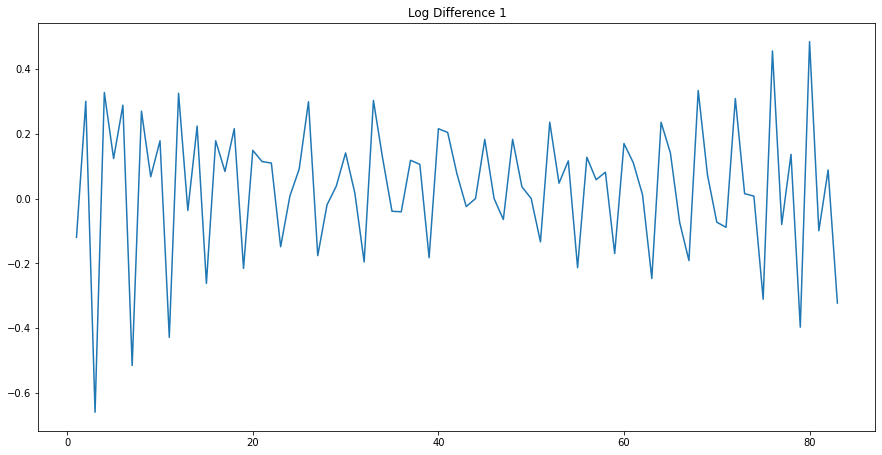

In [15]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['data'])
plt.title("Log Difference 1")
plt.show()

In [16]:
# Seasonal differencing

data['data'] = data['data'].diff(4)
data = data.drop([1, 2, 3, 4], axis=0).reset_index(drop=True)
data.head()

date      data
0  1961-04-02  0.242778
1  1961-07-02 -0.011834
2  1961-10-01  0.144006
3  1962-01-01 -0.057351
4  1962-04-02 -0.056093

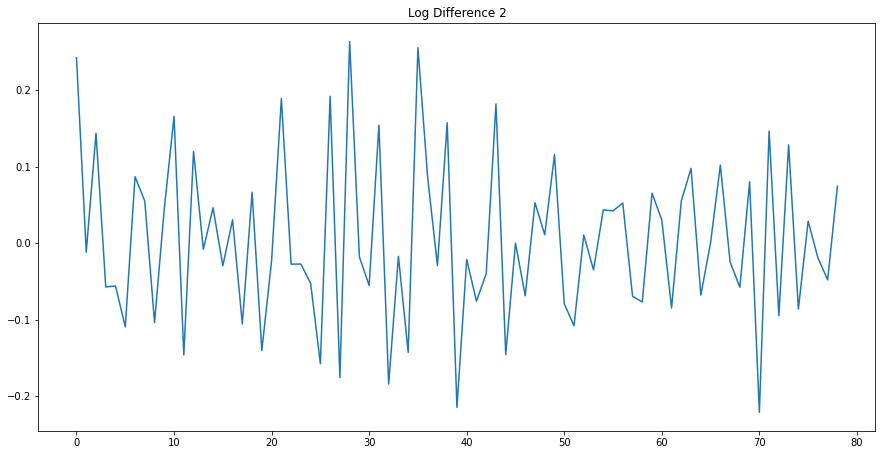

In [17]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['data'])
plt.title("Log Difference 2")
plt.show()

In [18]:
# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.630805109914263
p-value: 5.72157869513621e-09


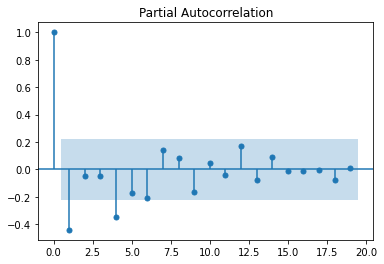

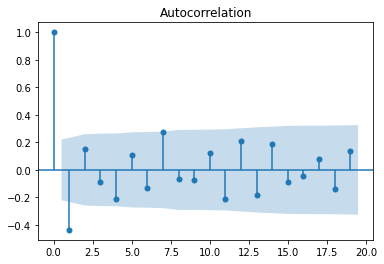

In [19]:
plot_pacf(data['data']);
plot_acf(data['data']);

In [20]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [21]:
## SARIMA grid of hyperparameters
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [22]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, data['data'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

(p,q)x(P,Q)         AIC
0    (0, 2, 0, 2) -114.458756
1    (0, 2, 1, 2) -114.254225
2    (0, 2, 1, 3) -113.518910
3    (0, 2, 0, 3) -113.077435
4    (0, 2, 2, 2) -113.043757
..            ...         ...
250  (0, 0, 1, 1)  -24.752956
251  (0, 0, 0, 1)  -23.122474
252  (1, 0, 0, 0)  -19.068827
253  (0, 0, 1, 0)    2.594264
254  (0, 0, 0, 0)   25.090985

[255 rows x 2 columns]

In [23]:
best_model = SARIMAX(data['data'], order=(0, 1, 2), seasonal_order=(0, 1, 2, 4)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              data   No. Observations:                   79
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 4)   Log Likelihood                  62.229
Date:                           Mon, 24 Jan 2022   AIC                           -114.459
Time:                                   11:18:41   BIC                           -102.938
Sample:                                        0   HQIC                          -109.863
                                            - 79                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5835      0.146    -10.860      0.000      -1.869      -1.298
ma.L2          0.5929      0.114      5.185

''

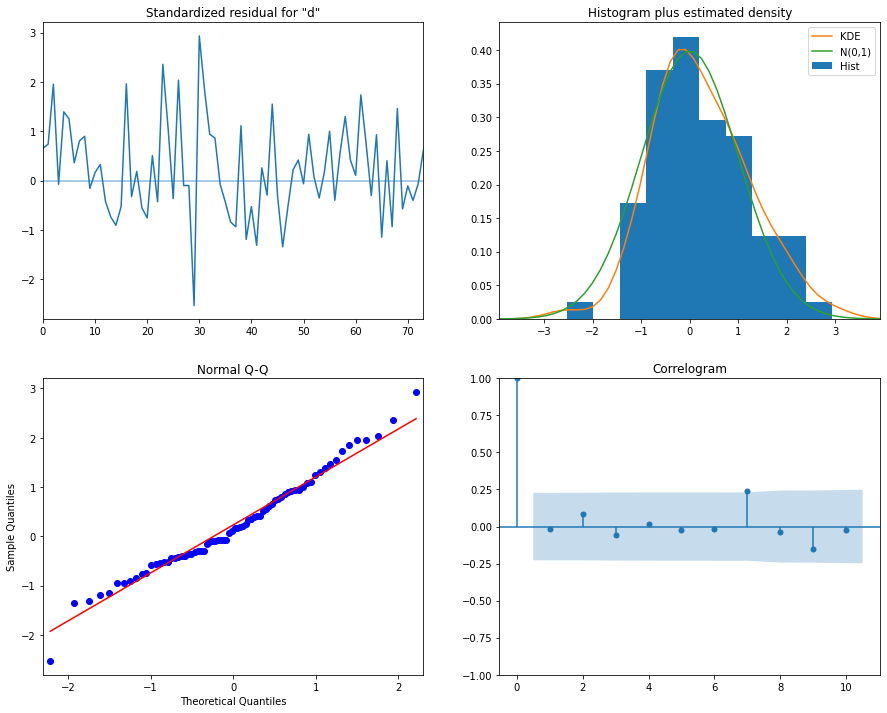

In [27]:
best_model.plot_diagnostics(figsize=(15,12))
""

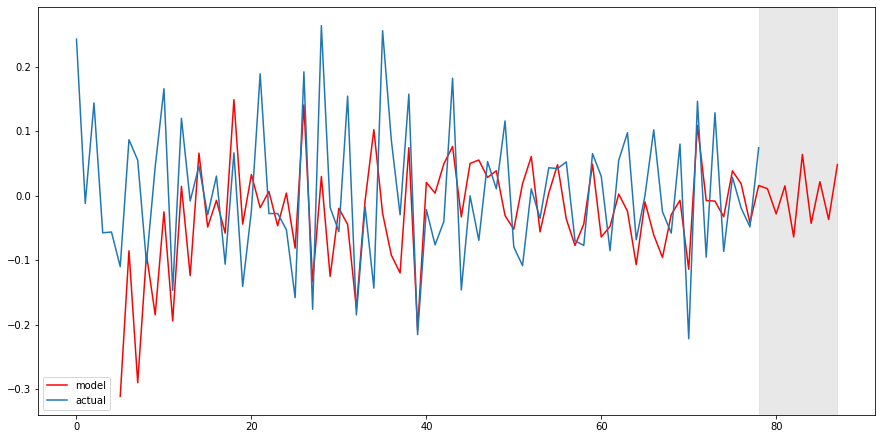

In [28]:
data['arima_model'] = best_model.fittedvalues
data['arima_model'][:4+1] = np.NaN

forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 8)
forecast = data['arima_model'].append(forecast)

plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data['data'], label='actual')
plt.legend()

plt.show()

## Exponential Smoothing (Holt-Winters) 

In [29]:
data = pd.read_csv('data.csv')
data.shape

(84, 2)

In [30]:
train, test = data.iloc[:75,:], data.iloc[75:,:]

In [31]:
model = ExponentialSmoothing(train['data'], seasonal='mul', seasonal_periods=4).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

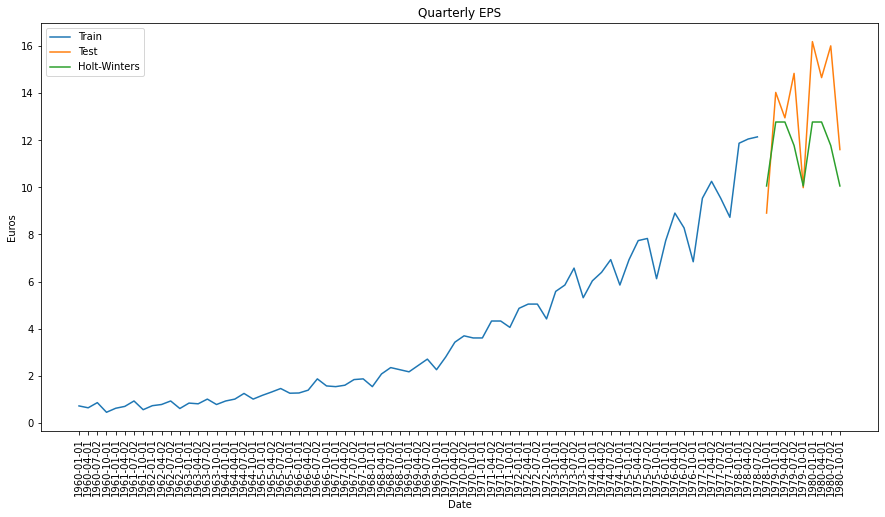

In [32]:
plt.figure(figsize=(15, 7.5))
plt.plot(train['date'], train['data'], label='Train')
plt.plot(test['date'], test['data'], label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.title('Quarterly EPS')
plt.ylabel('Euros')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.legend()
plt.show()